In [94]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt

import utils

# Load features and labels

In [95]:
data_path = '../data/'
# Load all users' work days
with open(data_path+'usr_work_days.pkl', 'rb') as f:
    USR_WORK_DAYS = pickle.load(f)


#label_path = '../data/03996723-2411-4167-b14b-eb11dfc33124/'
usr_id = '03996723-2411-4167-b14b-eb11dfc33124'
usr_path = data_path + usr_id + '/'

WIN_SIZE = 2 # second
OVERLAP = 0 # Zero overlapping between sliding windowss

features = list()
labels = list()

for day in USR_WORK_DAYS[usr_id]:
    print('Creating features on '+ day)
    data_fn = usr_path+'data'+day+'.npz'
    data = np.load(data_fn)
    ts = data['ts']
    offset = data['offset']
    accel = data['accel']
    gyro = data['gyro']
    step_cnt = data['step_cnt']
    act_type = data['act_type']
    lbl = data['labels']
    
    win_len = int(utils.INTERP_FREQ * WIN_SIZE) 
    overlap_len = int(utils.INTERP_FREQ * OVERLAP * WIN_SIZE)
    accel_x_wins = utils.generate_wins(accel[:, 0], win_len, overlap_len)
    accel_y_wins = utils.generate_wins(accel[:, 1], win_len, overlap_len)
    accel_z_wins = utils.generate_wins(accel[:, 2], win_len, overlap_len)
    
    gyro_x_wins = utils.generate_wins(gyro[:, 0], win_len, overlap_len)
    gyro_y_wins = utils.generate_wins(gyro[:, 1], win_len, overlap_len)
    gyro_z_wins = utils.generate_wins(gyro[:, 2], win_len, overlap_len)
    
    step_cnt_wins = utils.generate_wins(step_cnt[:, 0], win_len, overlap_len)
    act_type_wins = utils.generate_wins(act_type[:, 0], win_len, overlap_len)
    
    ts_features = list()
    for ts_win, offset_win in zip(ts_wins, offset_wins):
        ts_features.append([features.is_weekday(ts_win[0], offset_win[0])])
    ts_features = np.array(ts_features)
    
    
    
    
    label_wins = utils.generate_wins(lbl, win_len, overlap_len)
    
    print(lbl.shape)

    features.append(np.hstack([accel_x_wins, accel_y_wins, accel_z_wins,
                               gyro_x_wins, gyro_y_wins, gyro_z_wins,
                               step_cnt_wins, act_type_wins]))
    
    labels.append(label_wins)
features = np.vstack(features)
labels = np.vstack(labels)
#labels = stats.mode(labels, axis=1)[0][:, 0]

print('Feature matrix shape:', features.shape)
print('Label matrix shape:', labels.shape)

Creating features on 20171111
(21156,)
Creating features on 20171112
(858869,)
Creating features on 20171113
(791407,)
Creating features on 20171114
(575646,)
Creating features on 20171115
(793879,)
Creating features on 20171116
(804390,)
Creating features on 20171120
(796944,)
Creating features on 20171121
(771765,)
Creating features on 20171122
(768786,)
Creating features on 20171127
(734107,)
Creating features on 20171128
(851412,)
Creating features on 20171129
(771741,)
Creating features on 20171130
(540339,)
Creating features on 20171204
(802786,)
Creating features on 20171205
(734842,)
Creating features on 20171206
(834436,)
Creating features on 20171207
(850493,)
Creating features on 20171208
(833357,)
Creating features on 20171212
(833723,)
Creating features on 20171213
(774861,)
Creating features on 20171214
(819761,)
Creating features on 20171215
(826155,)
Creating features on 20171216
(731900,)
Creating features on 20171218
(790560,)
Creating features on 20171219
(811948,)
C

In [96]:
unique, counts = np.unique(stats.mode(labels, axis=1)[0][:, 0], return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 499358, 1.0: 144207}


# Balance classes and normailze feature matrix

In [97]:
win_labels = stats.mode(labels, axis=1)[0][:, 0]
zero_indices = np.where(win_labels==0)[0]
one_indices = np.where(win_labels==1)[0]

zero_indices = np.random.choice(zero_indices, size=one_indices.shape[0], replace=False)

indices = np.hstack((zero_indices, one_indices))

np.random.shuffle(indices)

new_labels = win_labels[indices]
#new_features = normalize(features[indices])
new_features = features[indices]
print('Feature matrix shape:', new_features.shape)
print('Label matrix shape:', new_labels.shape)

Feature matrix shape: (288414, 320)
Label matrix shape: (288414,)


# Create train set, validation set, and test set

In [98]:
num_classes = 2
split_idx = int(new_features.shape[0] * 0.80)

X_train = new_features[:split_idx]
Y_train = new_labels[:split_idx]

X_test = new_features[split_idx:]
Y_test = new_labels[split_idx:]

Y_train = keras.utils.to_categorical(Y_train, num_classes)
#Y_val = keras.utils.to_categorical(Y_val, num_classes)

print('train data shape:', X_train.shape)
print('train label shape:', Y_train.shape)
#print('val data shape:', X_val.shape)
#print('val label shape:', Y_val.shape)
print('test data shape:', X_test.shape)
print('test label shape:', Y_test.shape)

train data shape: (230731, 320)
train label shape: (230731, 2)
test data shape: (57683, 320)
test label shape: (57683,)


# Create MLP classifier

In [99]:
p = 0.3
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(keras.layers.Dense(units=256, 
                             activation='relu', 
                             input_dim=X_train.shape[1]))
model.add(keras.layers.Dense(units=128, 
                             activation='relu', 
                             input_dim=X_train.shape[1]))
# Add another:
model.add(keras.layers.Dropout(p))
model.add(keras.layers.Dense(units=64, activation='relu',
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(p))
model.add(keras.layers.Dense(units=64, activation='relu'))

# Add a softmax layer with 10 output units:
model.add(keras.layers.Dense(units=2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               82176     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 130       
Total para

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


# Train the model

In [100]:
epochs = 100
batch_size = 512
data_path = '.'
data_file = '/DNN_Model-10Second'


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])


checkpointer = keras.callbacks.ModelCheckpoint(filepath=data_path+data_file, 
                                               verbose=1,
                                               monitor='val_acc',
                                               save_best_only=True, 
                                               save_weights_only=False)

callbacks_list = [checkpointer]

H = model.fit(X_train, 
              Y_train, 
              batch_size=batch_size, 
              epochs=epochs, verbose=1, 
              shuffle=True, 
              validation_split=0.2,
              callbacks=callbacks_list)
#validation_data=(X_val, Y_val),

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Train on 184584 samples, validate on 46147 samples
Epoch 1/100
184584/184584 [==============================] - 3s 16us/step - loss: 0.6803 - acc: 0.6458 - val_loss: 0.6086 - val_acc: 0.6948

Epoch 00001: val_acc improved from -inf to 0.69484, saving model to ./DNN_Model-10Second
Epoch 2/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.6033 - acc: 0.6952 - val_loss: 0.5780 - val_acc: 0.7134

Epoch 00002: val_acc improved from 0.69484 to 0.71337, saving model to ./DNN_Model-10Second
Epoch 3/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.5780 - acc: 0.7081 - val_loss: 0.5496 - val_acc: 0.7318

Epoch 00003: val_acc improved from 0.71337 to 0.73184, saving model to ./DNN_Model-10Second
Epoch 4/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.5590 - acc: 0.7203 - val_loss: 0.5441 - val_acc: 0.7349

Epoch 00004: val_acc improved from 0.73184 to 0.73487, saving model to ./DNN_Model-10Second
Epoch 5/100
184584/1

Epoch 40/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4617 - acc: 0.7878 - val_loss: 0.4703 - val_acc: 0.7882

Epoch 00040: val_acc did not improve from 0.78965
Epoch 41/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4580 - acc: 0.7905 - val_loss: 0.4718 - val_acc: 0.7909

Epoch 00041: val_acc improved from 0.78965 to 0.79089, saving model to ./DNN_Model-10Second
Epoch 42/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4588 - acc: 0.7896 - val_loss: 0.4797 - val_acc: 0.7781

Epoch 00042: val_acc did not improve from 0.79089
Epoch 43/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4594 - acc: 0.7881 - val_loss: 0.4718 - val_acc: 0.7904

Epoch 00043: val_acc did not improve from 0.79089
Epoch 44/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4561 - acc: 0.7920 - val_loss: 0.4854 - val_acc: 0.7754

Epoch 00044: val_acc did not improve from 0.7908


Epoch 00080: val_acc did not improve from 0.80725
Epoch 81/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4325 - acc: 0.8061 - val_loss: 0.4622 - val_acc: 0.8022

Epoch 00081: val_acc did not improve from 0.80725
Epoch 82/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4341 - acc: 0.8049 - val_loss: 0.4580 - val_acc: 0.8056

Epoch 00082: val_acc did not improve from 0.80725
Epoch 83/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4347 - acc: 0.8055 - val_loss: 0.4642 - val_acc: 0.7940

Epoch 00083: val_acc did not improve from 0.80725
Epoch 84/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4334 - acc: 0.8067 - val_loss: 0.4764 - val_acc: 0.7816

Epoch 00084: val_acc did not improve from 0.80725
Epoch 85/100
184584/184584 [==============================] - 2s 12us/step - loss: 0.4343 - acc: 0.8044 - val_loss: 0.4548 - val_acc: 0.8072

Epoch 00085: val_acc did not improve fr

# Plot training accuracy vs testing accuracy

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


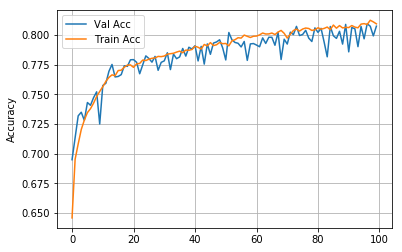

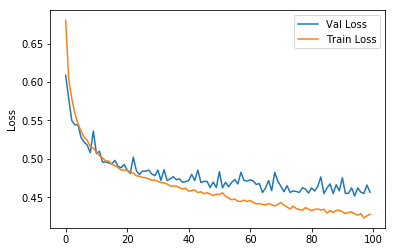

In [101]:
print(H.history.keys())

val_acc=H.history['val_acc']
acc = H.history['acc']

val_loss=H.history['val_loss']
loss = H.history['loss']


#fig= plt.figure(figsize=(15,10))
plt.plot(val_acc,label='Val Acc')
plt.plot(acc,label='Train Acc')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


#fig= plt.figure(figsize=(15,10))
plt.plot(val_loss,label='Val Loss')
plt.plot(loss,label='Train Loss')

plt.ylabel('Loss')
plt.legend()
plt.show()

# Print important window-wise metrics

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Confusion Matrix:
 [[21868  6907]
 [ 3884 25024]]
Accuracy: 0.81292581869875
F1 score: 0.8226302207465607


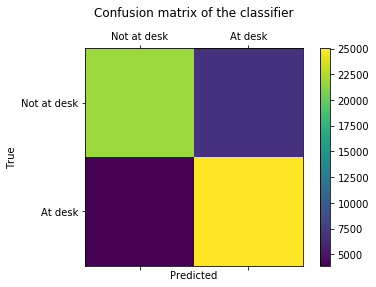

In [102]:
y_pred = np.argmax(model.predict(X_test), axis=1)

y_true = Y_test
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print('Confusion Matrix:\n', cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print('F1 score:', f1_score(y_true, y_pred))

class_labels = ['Not at desk', 'At desk']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier\n')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_labels)
ax.set_yticklabels([''] + class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print important element-wise metrics

In [103]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred = np.reshape(y_pred, (-1,1))
y_pred = np.repeat(y_pred, 40, axis=1)
y_pred = np.ravel(y_pred)

y_true = np.ravel(labels[indices][split_idx:])

cm = confusion_matrix(y_true, y_pred)

In [104]:
print(cm)
print(accuracy_score(y_true, y_pred))
print(f1_score(y_true, y_pred))

[[876301 279739]
 [153779 997501]]
0.812111887384498
0.8214888079982869


In [105]:
print(y_pred.shape)
print(y_true.shape)

(2307320,)
(2307320,)
